# Packages needed

In [22]:
#!pip install scikit-learn
#!pip install xgboost pandas

# Data procesing, description and ploting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tableone import TableOne as to
import pickle

# Data preprocessing
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# Feature selection 
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, mutual_info_classif, SelectFromModel, RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier 
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate, RandomizedSearchCV
from feature_engine.selection import MRMR


# Oversampling 
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.datasets import make_classification

# Predictive models
from sklearn.metrics import make_scorer, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from scipy.stats import randint, uniform


# Preprocessed data

In [23]:
x_train = pd.read_excel('E:\TFM Marta\Codis\Preprocessed_data_train.xlsx')
y_train = pd.read_excel('E:\TFM Marta\Codis\y_train.xlsx')

x_test = pd.read_excel('E:\TFM Marta\Codis\Preprocessed_data_test.xlsx')
y_test = pd.read_excel('E:\TFM Marta\Codis\y_test.xlsx')

In [24]:
y_train = y_train['RESPONSE']
y_test = y_test['RESPONSE']

x_train = x_train.drop(columns='Unnamed: 0')
x_test = x_test.drop(columns='Unnamed: 0')

# Zero-variance feature selection 

In [25]:
var = VarianceThreshold(threshold=0)  
x_train_reduced = var.fit_transform(x_train)
x_train_reduced = pd.DataFrame(x_train_reduced, columns=x_train.columns[var.get_support()])
print(f"Remaining features: {x_train_reduced.shape[1]}")
x_train = x_train_reduced

x_test_reduced = var.transform(x_test)
x_test_reduced = pd.DataFrame(x_test_reduced, columns=x_test.columns[var.get_support()])
x_test = x_test_reduced

Remaining features: 1580


# Feature selection approaches

## LASSO

In [26]:
# Lasso
lasso_cv = LassoCV(cv=5, random_state=2024, max_iter=50000)
lasso_cv.fit(x_train, y_train)
lasso_selected = lasso_cv.coef_ != 0 
X_train_lasso = x_train.loc[:, lasso_selected] 
print("Shape of LASSO-selected data:", X_train_lasso.shape)

lasso_selected_features = x_train.columns[lasso_selected]
print("Selected features:", lasso_selected_features)


KeyboardInterrupt: 

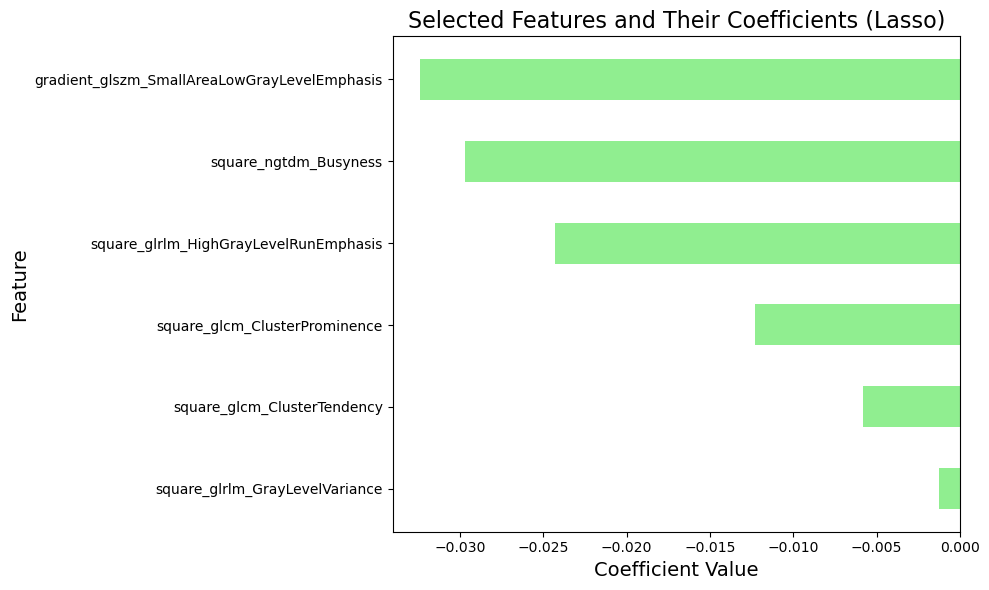

In [8]:
lasso_selected_features = x_train.columns[lasso_selected]
lasso_coefficients = lasso_cv.coef_[lasso_selected]

# Sort the coefficients and features based on their absolute values
sorted_idx = np.argsort(np.abs(lasso_coefficients))
lasso_selected_features_sorted = lasso_selected_features[sorted_idx]
lasso_coefficients_sorted = lasso_coefficients[sorted_idx]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(lasso_selected_features_sorted, lasso_coefficients_sorted, color='lightgreen', height=0.5)
plt.axvline(0, color='black', linewidth=0.5, linestyle='-')
plt.title('Selected Features and Their Coefficients (Lasso)', fontsize=16)
plt.xlabel('Coefficient Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()


## Random Forest

In [9]:
## Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=2024)
rf.fit(x_train, y_train)

importances = rf.feature_importances_
feature_importances_df = pd.DataFrame({
    'feature': x_train.columns,
    'importance': importances
})
selected_features = feature_importances_df.sort_values(by='importance', ascending=False).head(20)
X_train_rf = x_train[selected_features['feature']]

print(X_train_rf.columns)
print("Shape of RF-selected data:", X_train_rf.shape)

Index(['square_ngtdm_Busyness', 'wavelet-LLL_glszm_GrayLevelVariance',
       'lbp-3D-k_glszm_GrayLevelNonUniformityNormalized',
       'logarithm_glrlm_RunLengthNonUniformityNormalized',
       'wavelet-HLL_glszm_SizeZoneNonUniformity',
       'logarithm_gldm_DependenceVariance', 'wavelet-LHL_firstorder_Skewness',
       'wavelet-HHL_glszm_SmallAreaHighGrayLevelEmphasis',
       'square_glszm_ZoneEntropy', 'wavelet-LHH_firstorder_Median',
       'wavelet-HHL_glcm_Autocorrelation', 'original_glrlm_RunEntropy',
       'squareroot_glcm_MCC', 'EDAD',
       'gradient_glszm_LowGrayLevelZoneEmphasis', 'wavelet-LHL_glcm_MCC',
       'wavelet-HLL_glcm_MCC', 'gradient_glszm_SmallAreaLowGrayLevelEmphasis',
       'wavelet-LLL_firstorder_Variance',
       'wavelet-LHL_glcm_DifferenceEntropy'],
      dtype='object')
Shape of RF-selected data: (108, 20)


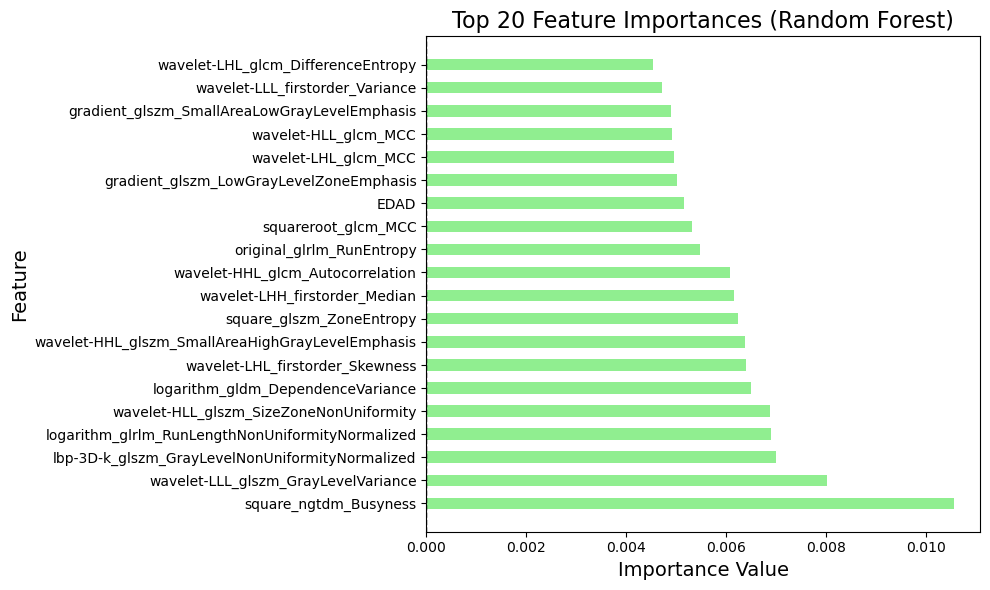

In [10]:
plt.figure(figsize=(10, 6))
plt.barh(selected_features['feature'], selected_features['importance'], color='lightgreen', height=0.5)  # Adjust height for thinner bars
plt.axvline(0, color='black', linewidth=1, linestyle='--')
plt.title('Top 20 Feature Importances (Random Forest)', fontsize=16)
plt.xlabel('Importance Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()

## ANOVA

In [11]:
# Calcular F-scores y p-values
F_scores, p_values = f_classif(x_train, y_train)

# Filtrar características con p-value bajo (ejemplo, menor que 0.05)
selected_p_value_indices = np.where(p_values < 0.05)[0]

# Ordenar por F-score de mayor a menor y seleccionar las 20 mejores
top_20_indices = np.argsort(F_scores[selected_p_value_indices])[-20:][::-1]  
selected_features = x_train.columns[selected_p_value_indices][top_20_indices]
top_20_F_scores = F_scores[selected_p_value_indices][top_20_indices]

# Filtrar los conjuntos de entrenamiento y prueba
X_train_anova = x_train[selected_features]
X_test_anova = x_test[selected_features]

# Resultados
print("Shape of ANOVA-selected data:", X_train_anova.shape)
print("Selected features:", selected_features)


Shape of ANOVA-selected data: (108, 20)
Selected features: Index(['square_glrlm_HighGrayLevelRunEmphasis',
       'square_glrlm_GrayLevelVariance', 'square_glcm_ClusterTendency',
       'square_glcm_SumSquares', 'square_glrlm_ShortRunHighGrayLevelEmphasis',
       'square_gldm_GrayLevelVariance', 'square_ngtdm_Complexity',
       'square_firstorder_Variance', 'square_glrlm_RunLengthNonUniformity',
       'gradient_glszm_SmallAreaLowGrayLevelEmphasis',
       'square_glcm_ClusterProminence', 'square_ngtdm_Busyness',
       'square_glcm_DifferenceVariance', 'square_firstorder_RootMeanSquared',
       'square_glcm_ClusterShade', 'square_glcm_Contrast',
       'logarithm_ngtdm_Busyness',
       'squareroot_gldm_LargeDependenceLowGrayLevelEmphasis',
       'lbp-3D-k_glszm_GrayLevelNonUniformityNormalized',
       'lbp-3D-k_glszm_GrayLevelVariance'],
      dtype='object')


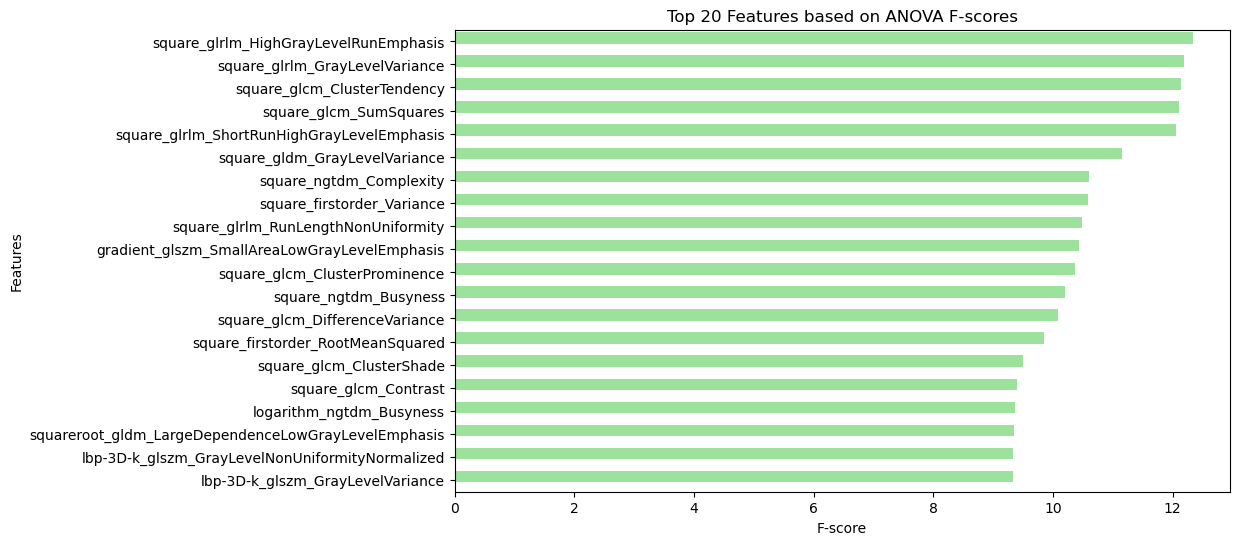

In [12]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_20_F_scores, y=selected_features, color='lightgreen', height=0.5)
plt.title('Top 20 Features based on ANOVA F-scores')
plt.xlabel('F-score')
plt.ylabel('Features')
plt.show()

## Minimal redundance and maximum importance (Mutual Information)

In [13]:
#!pip install feature-engine
MRMR_selector_MIQ = MRMR(method="MIQ", random_state=2024)
MRMR_selector_MIQ.fit(x_train, y_train)

vars = pd.Series(MRMR_selector_MIQ.relevance_, index=MRMR_selector_MIQ.variables_).sort_values(
    ascending=False)
vars20 = vars[:20]
vars20 = pd.Series(vars20)
selected_features = vars20.index.tolist()

X_train_MRMR_MIQ = x_train[selected_features]
X_test_MRMR_MIQ = x_train[selected_features]

print("Shape of MRMR-selected data:", X_train_MRMR_MIQ.shape)
print("Selected features:", X_train_MRMR_MIQ.columns)

c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: divide by zero encountered in divide
  mrmr = relevance / redundance
c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: invalid value encountered in divide
  mrmr = relevance / redundance
c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: divide by zero encountered in divide
  mrmr = relevance / redundance
c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: invalid value encountered in divide
  mrmr = relevance / redundance
c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: divide by zero encountered in divide
  mrmr = relevance / redundance
c:\Users\pcbox\anaconda3\Lib\site-packages\feature_engine\selection\mrmr.py:465: RuntimeWarning: invalid value encountered in divide
  mrmr = relevance / redundance
c:\User

Shape of MRMR-selected data: (108, 20)
Selected features: Index(['gradient_glcm_MaximumProbability', 'wavelet-HLL_firstorder_Range',
       'square_firstorder_10Percentile', 'wavelet-LHL_gldm_DependenceEntropy',
       'lbp-3D-k_glrlm_ShortRunEmphasis', 'wavelet-HHL_firstorder_Mean',
       'squareroot_glcm_ClusterProminence', 'square_glcm_Idmn',
       'squareroot_firstorder_Uniformity',
       'logarithm_glszm_SmallAreaLowGrayLevelEmphasis',
       'wavelet-HHL_ngtdm_Complexity', 'square_firstorder_Skewness',
       'square_firstorder_RootMeanSquared',
       'wavelet-LHL_gldm_SmallDependenceHighGrayLevelEmphasis',
       'original_glszm_HighGrayLevelZoneEmphasis',
       'exponential_firstorder_Entropy', 'wavelet-HHH_glcm_Correlation',
       'wavelet-HLH_glrlm_RunEntropy', 'wavelet-HHH_ngtdm_Complexity',
       'exponential_firstorder_MeanAbsoluteDeviation'],
      dtype='object')


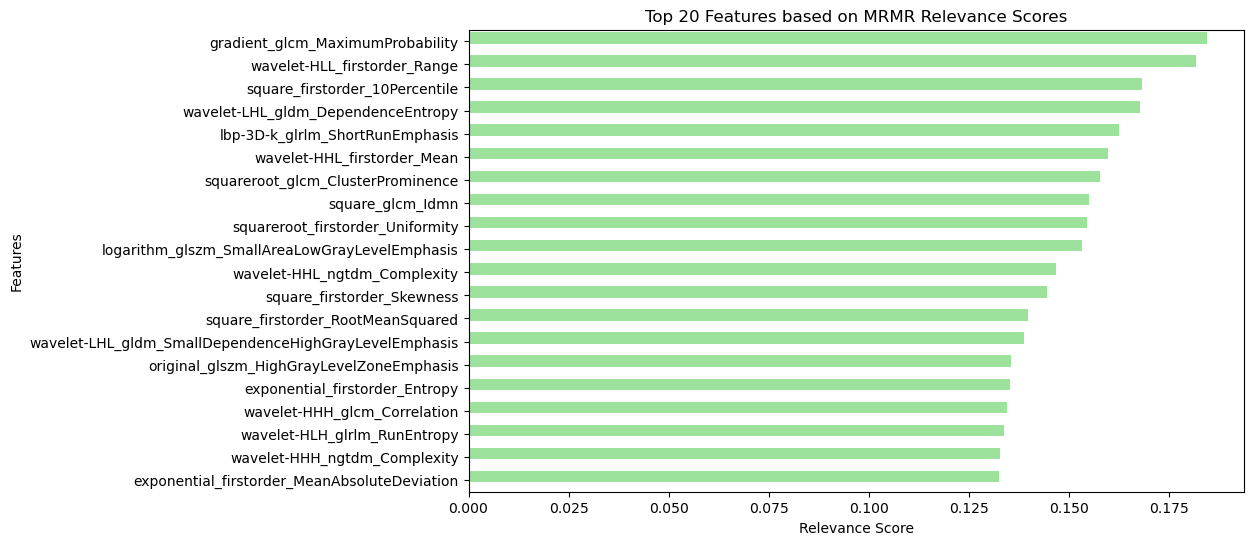

In [14]:
plt.figure(figsize=(10, 6))
sns.barplot(x=vars20.values, y=vars20.index, color='lightgreen', height=0.5)
plt.title('Top 20 Features based on MRMR Relevance Scores')
plt.xlabel('Relevance Score')
plt.ylabel('Features')
plt.show()

## Minimal redundance and maximum importance (Random Forest)

In [15]:
MRMR_selector_RF = MRMR(method="RFCQ", random_state=2024)
MRMR_selector_RF.fit(x_train, y_train)

vars = pd.Series(MRMR_selector_RF.relevance_, index=MRMR_selector_RF.variables_).sort_values(
    ascending=False)
vars20_RF = vars[:20]
selected_features = vars20_RF.index.tolist()

X_train_MRMR_RF = x_train[selected_features]
X_test_MRMR_RF = x_test[selected_features]

print("Shape of MRMR-selected data:", X_train_MRMR_MIQ.shape)
print("Selected features:", X_train_MRMR_MIQ.columns)

Shape of MRMR-selected data: (108, 20)
Selected features: Index(['gradient_glcm_MaximumProbability', 'wavelet-HLL_firstorder_Range',
       'square_firstorder_10Percentile', 'wavelet-LHL_gldm_DependenceEntropy',
       'lbp-3D-k_glrlm_ShortRunEmphasis', 'wavelet-HHL_firstorder_Mean',
       'squareroot_glcm_ClusterProminence', 'square_glcm_Idmn',
       'squareroot_firstorder_Uniformity',
       'logarithm_glszm_SmallAreaLowGrayLevelEmphasis',
       'wavelet-HHL_ngtdm_Complexity', 'square_firstorder_Skewness',
       'square_firstorder_RootMeanSquared',
       'wavelet-LHL_gldm_SmallDependenceHighGrayLevelEmphasis',
       'original_glszm_HighGrayLevelZoneEmphasis',
       'exponential_firstorder_Entropy', 'wavelet-HHH_glcm_Correlation',
       'wavelet-HLH_glrlm_RunEntropy', 'wavelet-HHH_ngtdm_Complexity',
       'exponential_firstorder_MeanAbsoluteDeviation'],
      dtype='object')


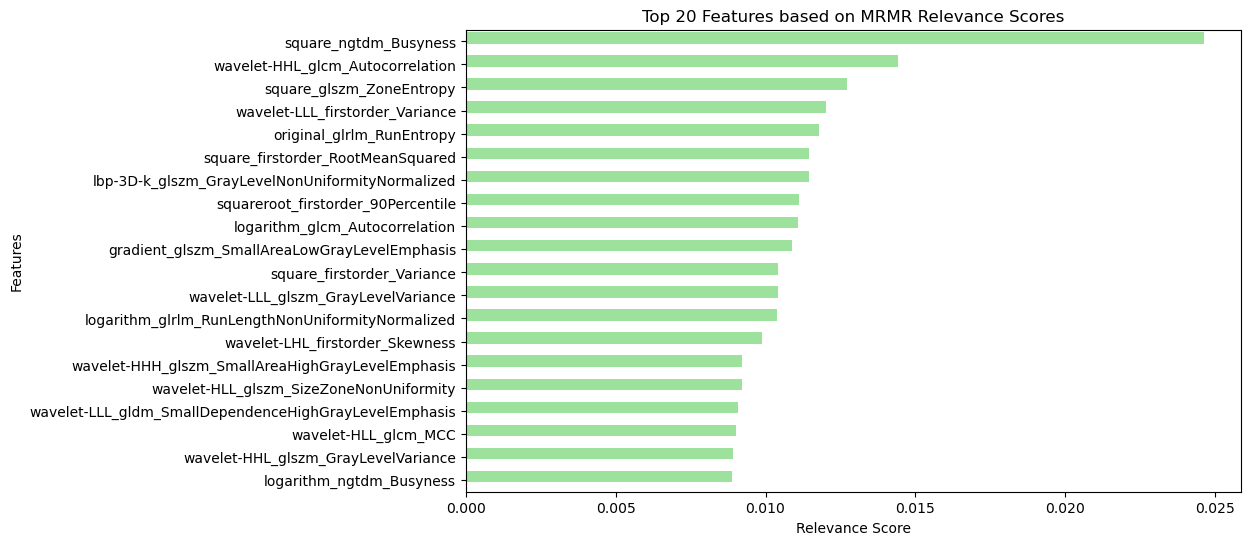

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x=vars20_RF.values, y=vars20_RF.index, color='lightgreen', height=0.5)
plt.title('Top 20 Features based on MRMR Relevance Scores')
plt.xlabel('Relevance Score')
plt.ylabel('Features')
plt.show()

# Feature and oversampled sets

In [17]:
# Diccionario para almacenar resultados
results = []

# List of feature sets
feature_sets = {
    'AllFeatures': x_train,
    'ANOVA': X_train_anova,
    'LASSO': X_train_lasso,
    'RF': X_train_rf,
    'mRMR_MIQ': X_train_MRMR_MIQ,
    'mRMR_RF': X_train_MRMR_RF
}

OvSampl = {
    'SMOTE': SMOTE(random_state=2024, k_neighbors=5),
    'SMOTETomek': SMOTETomek(random_state=2024),
    'ADASYN': ADASYN(random_state=2024),
    'RandomOverSampler': RandomOverSampler(random_state=2024)
}

saved_data = {}

# Iterar sobre cada conjunto de características
for feature_set_name, X_train in feature_sets.items():
    X_test = x_test[X_train.columns]

    for ovsampl_name, ovsampl_method in OvSampl.items():
        saved_data[(feature_set_name, ovsampl_name)] = {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,  # Asegúrate de tener y_train cargado previamente
            'y_test': y_test     # Asegúrate de tener y_test cargado previamente
        }

#with open('saved_data.pkl', 'wb') as f:
#    pickle.dump(saved_data, f)

# Predictive models

In [27]:
with open('saved_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

clfs = {
    'RandomForest': RandomForestClassifier(random_state=2024),
    'LogisticRegression': LogisticRegression(random_state=2024, max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'SVM': SVC(probability=True, random_state=2024),
    'XGBoost': xgb.XGBClassifier(objective="binary:logistic", random_state=2024),
    'MLPC': MLPClassifier(random_state=2024)
}

# Métricas de evaluación
scoring = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1_score': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

# Diccionario de parámetros de búsqueda de RandomizedSearchCV (ajustados según el clasificador)
param_distributions = {
    'RandomForest': {
        'n_estimators': randint(50, 200),
        'max_depth': randint(3, 15),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'bootstrap': [True, False]
    },
    'LogisticRegression': {
        'C': uniform(0.01, 10),
        'solver': ['liblinear', 'lbfgs'],
        'penalty': ['l1', 'l2']
    },
    'KNN': {
        'n_neighbors': randint(3, 15),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'SVM': {
        'C': uniform(0.01, 10),
        'kernel': ['linear', 'rbf'],
        'gamma': ['scale', 'auto'], 
        'probability': [True]
    },
    'XGBoost': {
        'n_estimators': randint(50, 200),
        'learning_rate': uniform(0.01, 0.2),
        'max_depth': randint(3, 10),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4)
    },
    'MLPC': {
        'hidden_layer_sizes': [(50, 30), (30, 20), (20,)],
        'max_iter': [100, 200, 300],
        'activation': ['relu', 'logistic'],
        'solver': ['adam', 'lbfgs'],
        'alpha': [0.0001, 0.001],
        'learning_rate': ['constant', 'adaptive'],
        'early_stopping': [True]
    }
}
results = []
# Iterar sobre cada combinación de feature_set y oversampling
for (feature_set_name, ovsampl_name), data in loaded_data.items():
    X_train = data['X_train']
    X_test = data['X_test']
    y_train = data['y_train']
    y_test = data['y_test']
    
    # Iterar sobre cada clasificador
    for clf_name, clf in clfs.items():
    
        # Realizar RandomizedSearchCV
        random_search = RandomizedSearchCV(
            clf, 
            param_distributions[clf_name],
            n_iter=50,
            cv=StratifiedKFold(n_splits=5),
            scoring='roc_auc', 
            random_state=2024,
            n_jobs=-1
        )

        random_search.fit(X_train, y_train)

        # Mejor modelo encontrado
        best_model = random_search.best_estimator_
        y_pred_prob = best_model.predict_proba(X_test)[:, 1]
        y_pred_test = best_model.predict(X_test)


        # Guardar los resultados
        results.append({
            'Feature Set': feature_set_name,
            'Oversampling Method': ovsampl_name,
            'Classifier': clf_name,
            'Best Params': random_search.best_params_,
            'Best ROC-AUC train score': random_search.best_score_,
            'y_pred_prob': y_pred_prob,
            'y_pred_test': y_pred_test,
            'Test Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_test),
            'Test Precision': precision_score(y_test, y_pred_test),
            'Test Recall': recall_score(y_test, y_pred_test),
            'Test F1-Score': f1_score(y_test, y_pred_test),
            'Test ROC-AUC': roc_auc_score(y_test, y_pred_prob)
        })

# Convertir los resultados en un DataFrame
results_df = pd.DataFrame(results)

# Mostrar los 10 mejores resultados ordenados por F1-score
sorted_results_df = results_df.sort_values(by='Test F1-Score', ascending=False)

#with open('sorted_results_df.pkl', 'wb') as f:
#    pickle.dump(sorted_results_df, f)

c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
35 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pcbox\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1194, in fit
    solver = 

# Best results
## Descriptive table

In [28]:
from IPython.display import display
#with open('sorted_results_df.pkl', 'rb') as f:
 #   results_df = pickle.load(f)

# Ordenar la tabla por F1-Score (opcional, para que los mejores estén arriba)
results_df = results_df.sort_values(by='Test F1-Score', ascending=False)

# Seleccionar columnas importantes para visualización
columns_to_display = [
    'Feature Set', 'Oversampling Method', 'Classifier', 
    'Best ROC-AUC train score', 'Test Balanced Accuracy', 'Test Precision', 
    'Test Recall', 'Test F1-Score', 'Test ROC-AUC'
]

# Filtrar y mostrar
results_table = results_df[columns_to_display].round(3)

# Mostrar tabla
display(results_table.head(10))


,Feature Set,Oversampling Method,Classifier,Best ROC-AUC train score,Test Balanced Accuracy,Test Precision,Test Recall,Test F1-Score,Test ROC-AUC
122,mRMR_RF,SMOTE,KNN,0.628,0.500,0.667,1.000,0.800,0.710
140,mRMR_RF,RandomOverSampler,KNN,0.628,0.500,0.667,1.000,0.800,0.710
97,mRMR_MIQ,SMOTE,LogisticRegression,0.542,0.500,0.667,1.000,0.800,0.457
134,mRMR_RF,ADASYN,KNN,0.628,0.500,0.667,1.000,0.800,0.710
115,mRMR_MIQ,RandomOverSampler,LogisticRegression,0.542,0.500,0.667,1.000,0.800,0.457
109,mRMR_MIQ,ADASYN,LogisticRegression,0.542,0.500,0.667,1.000,0.800,0.457
103,mRMR_MIQ,SMOTETomek,LogisticRegression,0.542,0.500,0.667,1.000,0.800,0.457
128,mRMR_RF,SMOTETomek,KNN,0.628,0.500,0.667,1.000,0.800,0.710
58,LASSO,SMOTETomek,XGBoost,0.656,0.528,0.680,0.944,0.791,0.457
64,LASSO,ADASYN,XGBoost,0.656,0.528,0.680,0.944,0.791,0.457


## Confusion Matrix and ROC Curve of the best model

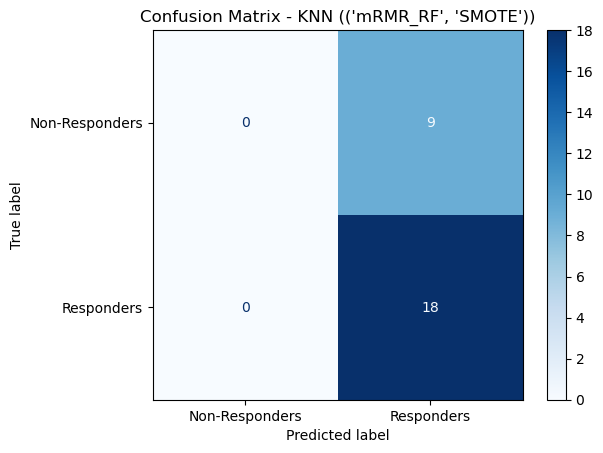

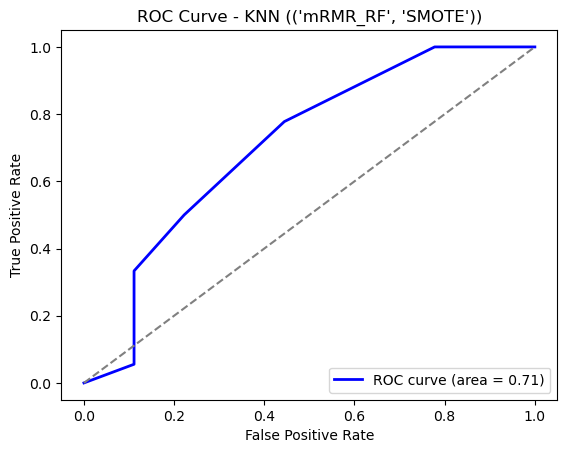

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import pickle

#with open('sorted_results_df.pkl', 'rb') as f:
#    sorted_results_df = pickle.load(f)
    
# Extraer los datos
best_model_row = results_df.loc[results_df['Test F1-Score'].idxmax()]
y_pred_prob = best_model_row['y_pred_prob']
y_pred_test = best_model_row['y_pred_test']

best_classifier = best_model_row['Classifier']
best_Oversampling_method = best_model_row['Oversampling Method']
best_feature_set = best_model_row['Feature Set']

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Responders', 'Responders'])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix - {best_classifier} ({best_feature_set, best_Oversampling_method})")
plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"ROC Curve - {best_classifier} ({best_feature_set, best_Oversampling_method})")
plt.legend(loc="lower right")
plt.show()
